# Generate Immobile/Mobile

- Labels trajectories as immobile/mobile given an sRg cutoff
- Remove mobile trajectories with TAMSD values below localization error estimate
- Generates a data frame with the resulting trajectories including sRg value, mobile/immobile class label and a "treatment" label
- Generates a data set of mobile TAMSD values (trajectories columnwise) without static noise correction

In [89]:
#requires trajAnalysis to check TAMSD power-law modeling parameters
source('trajAnalysis.R')
options(jupyter.plot_scale=1)

## Input parameters (see Ly et al. for details)
- The sRg cutoff is the 95-percentile of the sRg distribution in the fixed cell "small alpha" population
- The localization error estimate is the most likely value of the power-law coefficient parameter in the fixed cell "small alpha" population
- A "treatment" label
- Trajectories sRg and TAMSD file names
- Total number of lags for the power-law fit of TAMSD vs. lag 

In [92]:
cutoff<-2.22236433588659
noise<-0.33

In [67]:
#treatment label
mytreatment<-'untreated'

In [93]:
#Trajectories sRg and TAMSD file names
sRgFileName<-'testset-sRg-200.rds'
TAMSDfileName<-'testset-20-TAMSD-200.rds'

In [ ]:
#admit trajectories with a few lags under noise
#firstlag<-1

In [97]:
#use nlags to fit TAMSD vs lag to a power-law
nlags<-10

## Ouput file names

In [131]:
#TAMSD mobile and class data frame file names
TAMSDfileNameOut<-'testset-20-TAMSD-mobile-200.rds'
dataframeOut<-'testset-200.rds'

## Class and treatment assigment

In [98]:
#add 'class' and 'treatment' columns to the sRg data frame
bob<-readRDS(sRgFileName)
bob$class<-ifelse(bob$sRg>cutoff,"mobile","immobile")
bob$treatment<-mytreatment

## Mobile trajectories clean-up
- remove trajectories with TAMSD values below static noise
- remove trajectories with power-law exponents greater than 2

In [95]:
#mobile trajectory names
rns<-row.names(bob[bob$class=='mobile',])

In [96]:
#from the TAMSD list, generate a matrix of TAMSD values for the "mobile" trajectories (with each trajectory in one column)
msdm<-do.call(cbind,readRDS(TAMSDfileName))
myMSD<-msdm[,rns]
str(myMSD)

 num [1:20, 1:51] 1.19 2.74 4.11 5.57 6.72 ...
 - attr(*, "dimnames")=List of 2
  ..$ : NULL
  ..$ : chr [1:51] "AL_260_2024-04-19-TIRFM_Diff_tdT-MEFs_7-444" "AL_260_2024-04-19-TIRFM_Diff_tdT-MEFs_7-471" "AL_260_2024-04-19-TIRFM_Diff_tdT-MEFs_7-541" "AL_260_2024-04-19-TIRFM_Diff_tdT-MEFs_7-714" ...


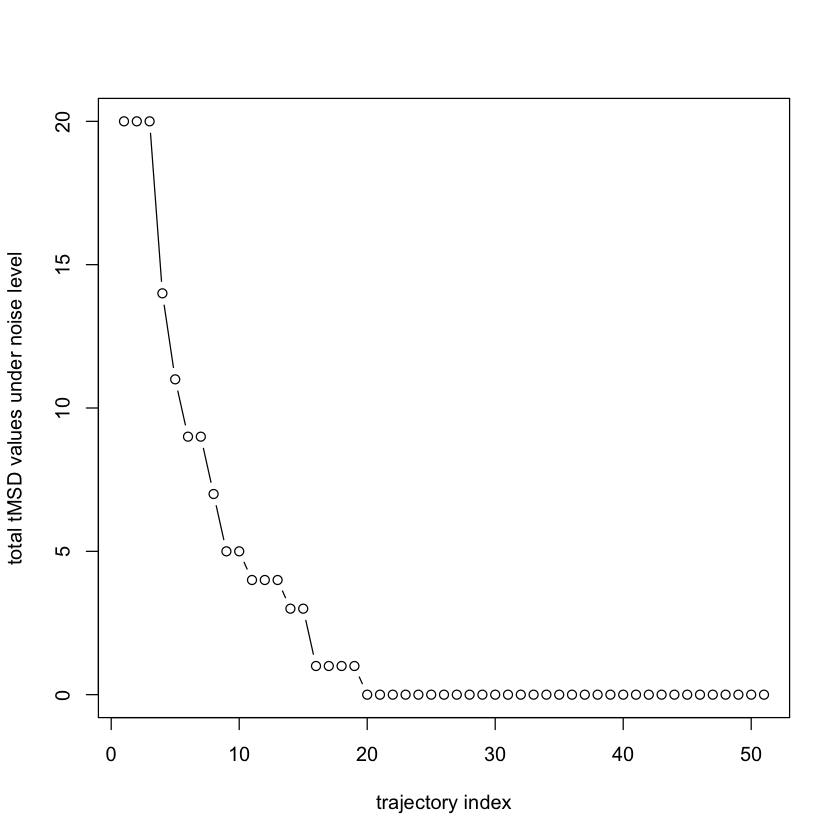

In [99]:
# check trajectories with TAMSD values under noise
plot(sort(apply(myMSD,2,function(z)length(which(z<noise))),
                decreasing = T),type='b',ylab='total tMSD values under noise level',xlab='trajectory index')

In [121]:
cmyMSD<-myMSD-noise
any(cmyMSD<0)

[1] TRUE

In [101]:
#remove trajectories with negative MSDs beyond permisible lags
if(any(cmyMSD<0)){
    baddies<-unique(which((cmyMSD<0),arr.ind = T)[,2])
cmyMSD<-cmyMSD[,-baddies]
    }
#any remaining negtaive lags? (there shouldn't be any)
#how many trajectories did you loose?
any(cmyMSD<0)
cat('number of trajectories excluded:',length(baddies),'\n')
cat('number of trajectories excluded:',length(baddies)/ncol(myMSD),'\n')

[1] FALSE

number of trajectories excluded: 19 
number of trajectories excluded: 0.372549 


In [103]:
#power-law fit
clags<-seq(1,nlags)
aDs<-t(apply(cmyMSD[seq_along(clags),],2,getAlphaD,lags=clags))
str(aDs)

 num [1:32, 1:2] 1.0337 0.0522 0.055 0.1464 0.1247 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:32] "AL_260_2024-04-19-TIRFM_Diff_tdT-MEFs_7-444" "AL_260_2024-04-19-TIRFM_Diff_tdT-MEFs_7-541" "AL_260_2024-04-19-TIRFM_Diff_tdT-MEFs_7-714" "AL_260_2024-04-19-TIRFM_Diff_tdT-MEFs_7-878" ...
  ..$ : NULL


In [126]:
#power-law exponent statistics
summary(aDs[,2])
cat('quantiles\n')
quantile(aDs[,2],probs = c(.95,.99,.999,.9999))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.1185  0.5944  0.8713  0.8414  1.0186  1.8384 

quantiles


95%      99%    99.9%   99.99% 
1.602441 1.778122 1.832333 1.837754

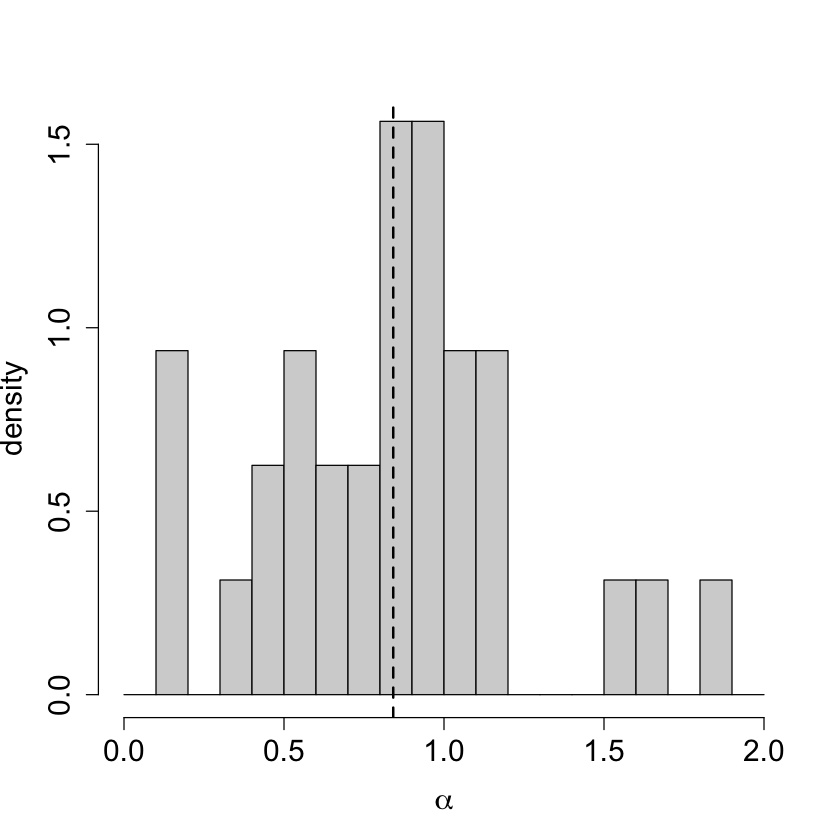

In [129]:
maxbreak<-if(max(aDs[,2])>2)max(aDs[,2])+.1 else 2
hist(aDs[goodones,2],breaks=seq(0,maxbreak,.1),
     xlim=c(0,maxbreak),probability = T,xlab = expression(alpha),main="",ylab='density',cex.lab=1.5,cex.axis=1.5)
abline(v=mean(aDs[goodones,2]),lty=2,lwd=2)

In [132]:
#entries with power-law exponent <= 2
goodones<-names(which(aDs[,2]<=2))
#make sure all entries have a row name
goodones<-goodones[which(sapply(goodones,nchar)>0)]

## Generate clean data sets and save

In [133]:
#save mobile trajectories without noise correction
saveRDS(myMSD[,goodones],TAMSDfileNameOut)

In [134]:
#fileter  data frame
bobsel<-rbind(bob[goodones,],bob[bob$class=="immobile",])

In [135]:
saveRDS(bobsel,dataframeOut)